# Using Normalizing Flows

[Normalizing flows](https://jmlr.org/papers/volume22/19-1028/19-1028.pdf) are a powerful tool for learning complex probability densities. What is great about normalizing flows is that they not only can generate samples from the distribution they learned, but can also tell you the probability of provided samples under the learned distribution. This comes at the price of the ability to learn fully arbitrary transformations of probability distributions. For example, normalizing flows cannot exchange the locations of positive and negative values along a coordinate - for that, you need at least partially stochastic mappings. In other words, normalizing flows only work because they apply a fully reversible (bijective) mapping to a coordinate. These can be *very* complicated mappings, but they must be reversible for the probability to be known. If we know a mapping from a specific coordinate $z$ to another coordinate $x = f(z)$, and the inverse mapping, $z = f^{-1}(x)$, we can immediately relate the probability distributions over $x$ and $z$ as
\begin{align}
    P_x(x) &= \frac{P_z(z)}{|\mathrm{det} J_f(z)|} = P_z(f^{-1}(x)) |\mathrm{det} J_{f^{-1}}(x)| \\
    P_z(z) &= \frac{P_x(x)}{|\mathrm{det} J_f(z)|} = P_x(f(z)) |\mathrm{det} J_f(z)|
\end{align}
In the above, $|\mathrm{det} J_f(z)|$ is the absolute value of the determinant of the Jacobian for the transformation $x = f(z)$. A Jacobian is typically a matrix of partial derivatives. For a simple 1D case, $|\mathrm{det} J_f(z)| = \partial f / \partial z$. We can see that as long as it is easy to compute the Jacobian determinant, we can exactly compute a probability if one of the probability densities is analytically known. The core innovation of normalizing flows is realizing how sophisticated neural network architectures can be used to learn very complicated, non-linear transformations that are fully reversible and for which the Jacobian determinants are easily computed.

Only one type of mapping function is implemented in the vaemolsim.flows module: [neural spline flows](https://arxiv.org/abs/1906.04032). These are a very flexible bijective function. To be succinct, we use neural networks to define rational quadratic splines with a chosen (fixed) number of spline knots. The input to these networks is either constants (ones in my implementation) or some portion of the coordinates to be transformed. We can never use the values to transform themselves to parametrize the spline transformation. It turns out this would remove the ability to easily calculate the Jacobian determinant of the transformation. For multidimensional distributions, knowledge of some of the coordinates are used to define transformations for the other coordinates. In the vaemolsim.flows module, there are two implementations of how this is done. One is based on an architecture referred to as [RealNVP](https://arxiv.org/abs/1605.08803), where the coordinates are simply split in half and multiple transformation blocks are stacked together to alternate transformations and in the end transform all the coordinates. Note that we can impose as many layers, and hence transformations, as we want as long as we do not use a coordinate to define its own transformation. Another option is to apply neural networks to *all* the coordinates, but with masks so that no coordinate influences its own transformation. This type of architecture is called [Masked Autoregressive Flows](https://arxiv.org/abs/1705.07057). It turns out that this option is capable of fully autoregressive transformations, meaning that fully conditional dependencies can be rigorously built into the distribution. A fully autoregressive probability density model is defined as $P(\mathbf{x}) = P(x_1) \displaystyle \prod_{i=2} P(x_i | x_j<i)$. In practice, this means you sample the first degree and use its value to help define the probability distribution for all subsequent degrees of freedom. Similarly, the second coordinate defines all coordinates sampled after it.

Now that we've discussed all of the theory, let's check out how to use normalizing flows with the vaemolsim.flows module.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from vaemolsim import flows, losses, models

import matplotlib.pyplot as plt

The first thing to do is define a probability density to transform, sometimes called a "latent distribution." We typically want to use something simple that we know the analytical distribution of. There are many distributions in TensorFlow Probability to choose from. Here, we start with a standard normal. Note that we apply `tfp.distributions.Independent` to ensure that the distribution will be interpreted as having shape of one (`event_shape` = 1) in the number of coordinates sampled. Another way to accomplish this would be to use `tfp.distributions.MultivariateNormalDiag`, but we will not go into that here.

In [2]:
latent_dist = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros((1,)), scale=tf.ones((1,))),
                                            reinterpreted_batch_ndims=1)
# Alternatively...
# latent_dist = tfp.distributions.MultivariateNormalDiag(loc=[0.0,], scale_diag=[1.0,])
latent_sample = latent_dist.sample(100000)

In [3]:
latent_dist

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[1] dtype=float32>

Briefly notice that the sampe of the latent sample is the number of samples we asked for (10000), by the dimensionality of the "loc" and "scale" vectors, which here is 1. That's to get the `event_shape` right.

In [4]:
latent_sample.shape

TensorShape([100000, 1])

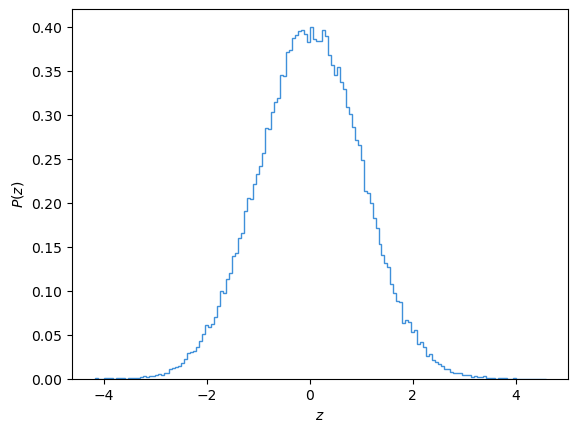

In [5]:
fig, ax = plt.subplots()
hist, bins, patches = ax.hist(np.squeeze(latent_sample), bins='auto', density=True, histtype='step')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$P(z)$')
plt.show()

Next, we will define our flow that transforms this distribution. We will just use a RealNVP architecture here, since we get nothing extra from a Masked Autoregressive Flow (MAF) for just a single dimension. Additionally, RealNVP is slightly more efficient, so only use a MAF if you feel there are complex correlations that you want to capture *in multiple dimensions*.

In [6]:
flow = flows.RQSSplineRealNVP(
    num_blocks=4, # Number of transformation blocks
    # The below dictionary of parameters defines aspects of the neural rational quadratic splines
    rqs_params={'bin_range': [-10, 10], # List of min and max values for transformation - data outside this range will NOT be transformed!
                'num_bins': 32, # Number of bins - more is a more powerful transformation but is more expensive
                'hidden_dim': 100, # Number of hidden dimensions in neural networks (should be more than num_bins, ideally)
               }, 
)

One gotcha: for the flow to get "built" right, it first has to operate on some actual data. So we either need to supply some random data of the right dimensionality, or transform a latent sample directly. Let's do that and see how the distribution changes.

In [7]:
transformed_latent_sample = flow(latent_sample)

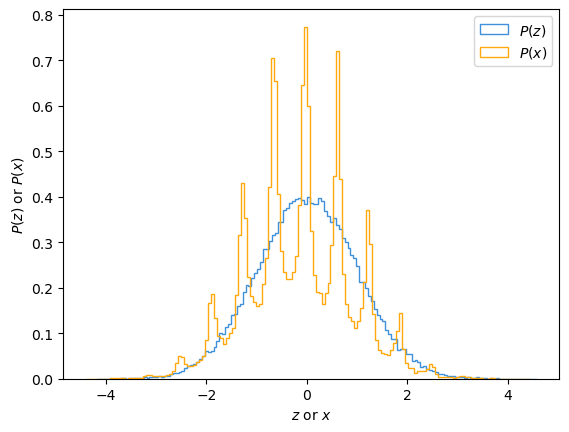

In [8]:
fig, ax = plt.subplots()
hist, bins, patches = ax.hist(np.squeeze(latent_sample), bins='auto', density=True, histtype='step', label=r'$P(z)$')
hist, bins, patches = ax.hist(np.squeeze(transformed_latent_sample), bins='auto', density=True, histtype='step', label=r'$P(x)$')
ax.set_xlabel(r'$z$ or $x$')
ax.set_ylabel(r'$P(z)$ or $P(x)$')
ax.legend()
plt.show()

Thanks to some really nice aspects of how TensorFlow Probability works, we can create a transformed distribution by just calling our flow on a TFP distribution, like so. Then we can sample from that, or evaluate probabilities, as shown, just like for any other distribution. So we can just think of a flowed distribution as a really complicated distribution.

In [9]:
transformed_dist = flow(latent_dist)
transformed_sample = transformed_dist.sample(100000)
transformed_dist.log_prob(transformed_sample)

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([-0.5357801 , -1.8204608 , -0.2987222 , ..., -1.2383195 ,
       -0.38076895, -0.40323955], dtype=float32)>

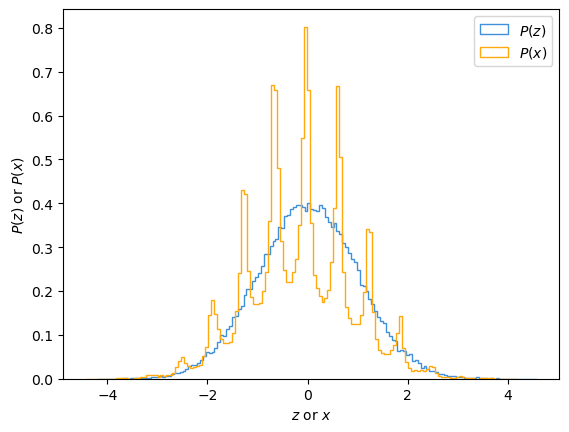

In [10]:
fig, ax = plt.subplots()
hist, bins, patches = ax.hist(np.squeeze(latent_sample), bins='auto', density=True, histtype='step', label=r'$P(z)$')
hist, bins, patches = ax.hist(np.squeeze(transformed_sample), bins='auto', density=True, histtype='step', label=r'$P(x)$')
ax.set_xlabel(r'$z$ or $x$')
ax.set_ylabel(r'$P(z)$ or $P(x)$')
ax.legend()
plt.show()

The next step is to give ourselves a target to train on. Let's do something tricky, with multiple peaks. Pay no mind to what's going on with TensorFlow probability - this is a bit sophisticated, but there is documentation for how to do it.

In [11]:
target_dist = tfp.distributions.Independent(
    tfp.distributions.Mixture(
    cat=tfp.distributions.Categorical(probs=[[0.5, 0.1, 0.3, 0.1],]),
    components=[tfp.distributions.Normal(loc=-2.0*tf.ones((1,)), scale=tf.ones((1,))),
                tfp.distributions.Normal(loc=tf.zeros((1,)), scale=tf.ones((1,))),
                tfp.distributions.Normal(loc=2.0*tf.ones((1,)), scale=0.2*tf.ones((1,))),
                tfp.distributions.Normal(loc=3.5*tf.ones((1,)), scale=0.5*tf.ones((1,))),
               ],
    ),
    reinterpreted_batch_ndims=1,
)
target_sample = target_dist.sample(100000)

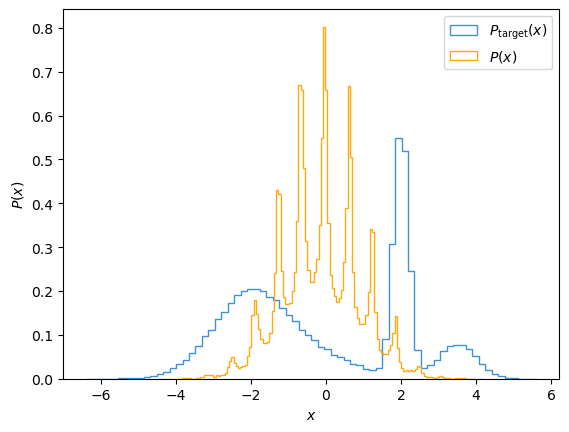

In [12]:
fig, ax = plt.subplots()
hist, bins, patches = ax.hist(np.squeeze(target_sample), bins='auto', density=True, histtype='step', label=r'$P_\mathrm{target}(x)$')
hist, bins, patches = ax.hist(np.squeeze(transformed_sample), bins='auto', density=True, histtype='step', label=r'$P(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x)$')
ax.legend()
plt.show()

At this point, the flow looks nothing like the target distribution... To actually train the flow, the best way is to use the `FlowModel` class within the vaemolsim.models module. This is just a convenient wrapper for working with flows directly. For this to work, though, what we pass for `latent_dist` must take inputs and output a distribution object. This provides much more flexibility around a flow. For example, a neural network transformation of the inputs could be applied to generate parameters for the starting distribution, with this model then acting like a decoder. Or, we might want our flow to depend conditionally on some other information that is supplied, which will be the inputs to the layer. In that case, the latent distribution will still be fixed and not have any dependence on the inputs. Both scenarios are possible in `FlowModel`.

Either way, we need to wrap our distribution in a special TFP class as follows:

In [13]:
lambda_latent_dist = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros((tf.shape(t)[0], 1)),
                                                                                                                                          scale=tf.ones((tf.shape(t)[0], 1))),
                                                                                                                reinterpreted_batch_ndims=1)
                                                   )
# lambda_latent_dist = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfp.distributions.Blockwise([tfp.distributions.Normal(loc=tf.zeros((tf.shape(t)[0],)), scale=tf.ones((tf.shape(t)[0],))),]))
flow_model = models.FlowModel(flow,
                              lambda_latent_dist,
                             )

And now we can compile and train the model on some target data.

In [14]:
flow_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
                   loss=losses.LogProbLoss(),
                  )

In [15]:
flow_model.fit(latent_sample, target_sample, epochs=10)
# Note that latent_sample will be ignored (DistributionLambda only uses its shape)

Epoch 1/10
3125/3125 [==============================] - 10s 2ms/step - loss: 1.8821
Epoch 2/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8598
Epoch 3/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8573
Epoch 4/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8571
Epoch 5/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8553
Epoch 6/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8533
Epoch 7/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8528
Epoch 8/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8525
Epoch 9/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8518
Epoch 10/10
3125/3125 [==============================] - 5s 2ms/step - loss: 1.8517


Training is done! Note that TFP bijector objects used in flows are almost too clever in that they recognize if they have computed a transformation of a given variable before. That means we have to resample from the latent distribution to get a new look at the flow.

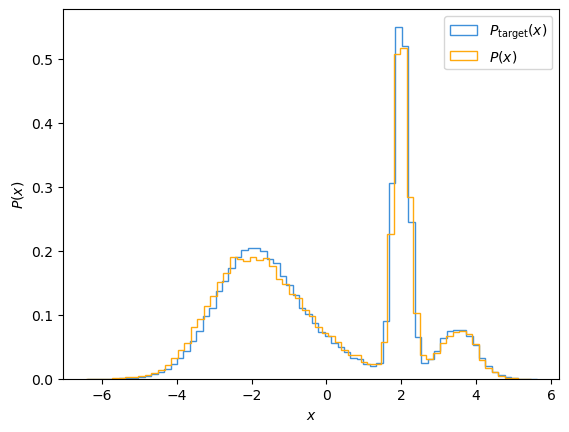

In [16]:
latent_sample = latent_dist.sample(100000)
trained_transformed_sample = flow(latent_sample)
fig, ax = plt.subplots()
hist, bins, patches = ax.hist(np.squeeze(target_sample), bins='auto', density=True, histtype='step', label=r'$P_\mathrm{target}(x)$')
hist, bins, patches = ax.hist(np.squeeze(trained_transformed_sample), bins='auto', density=True, histtype='step', label=r'$P(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x)$')
ax.legend()
plt.show()